# Praktische Übung 6: Neural Networks - Lösung


### 0. Preamble

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(1)
np.random.seed(1)

The following lines checks for GPU availability on the machine and sets the GPU as processing device (if available). If you are on Google Colab you can enable GPU support in the menu via `Runtime > Change runtime type` and select `GPU` as hardware accelerator.

In [2]:
if(torch.cuda.is_available()):
  processing_chip = "cuda:0"
  print(f"{torch.cuda.get_device_name(0)} available")
else:
  processing_chip = "cpu"
  print("No GPU available")

device = torch.device(processing_chip)
device

No GPU available


device(type='cpu')

### 1. Data Preperation

We work with the already know digit dataset. For more details on the dataset, check our [previous](https://github.com/pabair/ml-kurs-ss21/blob/master/2_Logistische_Regression_Digits.ipynb) notebook.


In [3]:
from sklearn.datasets import load_digits
data, labels = load_digits(return_X_y = True)

In [4]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data, labels, test_size=0.2, random_state=0)

In [5]:
train_X

array([[ 0.,  0.,  0., ..., 16., 16.,  6.],
       [ 0.,  3., 12., ..., 16.,  2.,  0.],
       [ 0.,  1., 10., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  4., ...,  0.,  0.,  0.],
       [ 0.,  0.,  6., ..., 11.,  0.,  0.]])

To be able to use the data in PyTorch, we need to convert them into PyTorch tensors. Such a tensor can be thought of an efficient way to represent lists and matrices (similar to Numpy), with the additional benefit that they can be moved to the GPU (the .to(device) part in the code below) and that they support automatic backpropagation (more on this later):

In [6]:
train_x = torch.Tensor(train_X).float().to(device)
test_x = torch.Tensor(test_X).float().to(device)
train_y =torch.Tensor(train_y).long().to(device)
test_y = torch.Tensor(test_y).long().to(device)

### 2. Model definition 


We define now the strucutre of our neural network. For this we create a class that is a subclass from PyTorch's nn.Module. By convention we put in the `__init__` method the layers we want to use in the network and in the `forward` method how data flows through this network.

Our network has 64 input features, one hidden layer with 5 neurons and 10 output neurons. The hidden layer uses a Relu activation function. Note that the output layer does not have a softmax activation (unlike we have seen it in the lecture). It rather gives out a raw score for each class (more on this later).

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden1 = nn.Linear(64, 10) # Task 1
    self.hidden2 = nn.Linear(10, 5)  # Task 1
    self.output = nn.Linear(5, 10)

  def forward(self, x):
    z = F.relu(self.hidden1(x))
    z = F.relu(self.hidden2(z)) # Task 1
    z = self.output(z)  # no softmax. see CrossEntropyLoss() 
    return z

### 3. Model Training

We can now start training our network. We run several epochs in which we first predict on the training data with our network and than backpropagate the loss. For this we use PyTorch's build-in optimizer that runs gradient descent on the weights of the network. Hence, in every episode we reduce the loss on the training data and improve our network.

As loss function we use cross entropy, which consumes the raw scores from the prediction and internally applies a softmax (that is why we do not need the softmax as last layer in the network).

Note that all training data is passed at once to our network (line `net(train_x)` ), since PyTorch will predict on all data points in parallel.

In [8]:
# create network, move it to device and set it to training-mode
net = Net().to(device)
net.train()

Net(
  (hidden1): Linear(in_features=64, out_features=10, bias=True)
  (hidden2): Linear(in_features=10, out_features=5, bias=True)
  (output): Linear(in_features=5, out_features=10, bias=True)
)

In [9]:
# create network, move it to device and set it to training-mode
net = Net().to(device)
net.train()

# define the parameters for training
no_epochs = 10000
learning_rate = 0.01
loss_func = nn.CrossEntropyLoss()  # applies softmax() internally
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

print("\nStarting training ")

train_losses = []
test_losses = []
for epoch in range(0, no_epochs):

  optimizer.zero_grad()
  output = net(train_x)

  loss = loss_func(output, train_y)
  loss.backward()
  optimizer.step()

  y_hat_test = net(test_x)
  loss_test = loss_func(y_hat_test, test_y)

  train_losses.append(loss.item())
  test_losses.append(loss_test.item())
  
  if epoch % 100 == 0:
    print(f"Loss in epoch {epoch} is {loss.item()}")

print("Done training ")


Starting training 
Loss in epoch 0 is 2.768087387084961
Loss in epoch 100 is 1.8456432819366455
Loss in epoch 200 is 1.5123120546340942
Loss in epoch 300 is 1.283310890197754
Loss in epoch 400 is 1.1420927047729492
Loss in epoch 500 is 0.9864488244056702
Loss in epoch 600 is 0.7818663716316223
Loss in epoch 700 is 0.6709215044975281
Loss in epoch 800 is 0.5803940892219543
Loss in epoch 900 is 0.4972643256187439
Loss in epoch 1000 is 0.4304571747779846
Loss in epoch 1100 is 0.37476667761802673
Loss in epoch 1200 is 0.3190990090370178
Loss in epoch 1300 is 0.26466989517211914
Loss in epoch 1400 is 0.22832602262496948
Loss in epoch 1500 is 0.20401905477046967
Loss in epoch 1600 is 0.18581870198249817
Loss in epoch 1700 is 0.17134864628314972
Loss in epoch 1800 is 0.15933029353618622
Loss in epoch 1900 is 0.14909332990646362
Loss in epoch 2000 is 0.14020377397537231
Loss in epoch 2100 is 0.13237212598323822
Loss in epoch 2200 is 0.12521572411060333
Loss in epoch 2300 is 0.1187385767698288

Text(0, 0.5, 'loss')

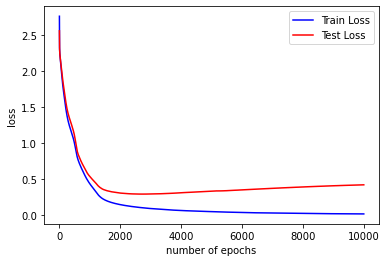

In [10]:
fig = plt.figure()
plt.plot(range(0, no_epochs), train_losses, color='blue')
plt.plot(range(0, no_epochs), test_losses, color='red')
plt.legend(['Train Loss', "Test Loss"], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('loss')

### 4. Model Evaluation

Finally, we check the model accuracy on the test data. For this we predict on the test data, identify the class with the highest score and compare it to the true label.

In [11]:
net.eval() # set network to evaluation mode
y_pred = net(test_x)
_, predicted = torch.max(y_pred.data, 1)
correct = (predicted == test_y).sum().item()
print(f"Accuarcy is {100. * correct / len(test_x)}%")

Accuarcy is 91.38888888888889%


### 5. Tasks

1. Our accuracy is not so good on the test data. Try the following to improve the model:
    - Increase the hidden layer size to 10 neurons, train the model and compare the accuracy on the test data.
    - Add a second hidden layer with 5 neurons, train the model and compare the accuracy on the test data.
2. Check if you can decrease the training loss even further if you train for more epochs. However, this can easily result in overfitting. To check that, calculate the accuracy on the test data already during training after each epoch. Show the plot the results as a second plot similiar to the one above. (Note: Normally we need to do this check on seperate validation data, not on our test data).
3. Take the titanic data set and try to train a neural network on it.

### Solutions:
1. Accuracy can be improved to 81%. See code changes above.
2. We can see that test loss does not get better after 2000 epochs

#### Task 3: Titanic data

In [12]:
import pandas as pd
df = pd.read_csv("../data/titanic.csv")
df_selection = df[["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]]
df_selection = df_selection.dropna()

In [13]:
df_X = df_selection.drop(columns = ["Survived"]).values
df_y = df_selection["Survived"].values
train_x, test_x, train_y, test_y = train_test_split(df_X, df_y, test_size=0.2, random_state=0)

What is important above is that we transform the Pandas objects into numpy nd-arrays by applying the `.values`, because PyTorch does not really like to create tensors out of Pandas DataFrames or Series.

In [14]:
train_x = torch.Tensor(train_x).float().to(device)
test_x = torch.Tensor(test_x).float().to(device)
train_y = torch.Tensor(train_y).long().to(device)
test_y = torch.Tensor(test_y).long().to(device)

In [15]:
class TitanicNet(nn.Module):
  def __init__(self):
    super(TitanicNet, self).__init__()
    self.hidden = nn.Linear(5, 10)
    self.output = nn.Linear(10, 2)

  def forward(self, x):
    z = F.relu(self.hidden(x))
    z = self.output(z)  # no softmax. see CrossEntropyLoss() 
    return z

In [16]:
net = TitanicNet().to(device)
net.train()

# define the parameters for training
no_epochs = 10000
learning_rate = 0.01
loss_func = nn.CrossEntropyLoss()  # applies softmax() internally
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

print("\nStarting training ")

train_losses = []
test_losses = []
for epoch in range(0, no_epochs):

  optimizer.zero_grad()
  output = net(train_x)

  loss = loss_func(output, train_y)
  loss.backward()
  optimizer.step()

  y_test = net(test_x)
  loss_test = loss_func(y_test, test_y)

  train_losses.append(loss.item())
  test_losses.append(loss_test.item())
  
  if epoch % 100 == 0:
    print(f"Loss in epoch {epoch} is {loss.item()}")

print("Done training ")


Starting training 
Loss in epoch 0 is 1.4843826293945312
Loss in epoch 100 is 0.5951008200645447
Loss in epoch 200 is 0.5931857228279114
Loss in epoch 300 is 0.5906314253807068
Loss in epoch 400 is 0.5895885229110718
Loss in epoch 500 is 0.5888893604278564
Loss in epoch 600 is 0.5881949067115784
Loss in epoch 700 is 0.5873887538909912
Loss in epoch 800 is 0.586796224117279
Loss in epoch 900 is 0.5856370329856873
Loss in epoch 1000 is 0.5846630930900574
Loss in epoch 1100 is 0.585145890712738
Loss in epoch 1200 is 0.583357572555542
Loss in epoch 1300 is 0.5823001265525818
Loss in epoch 1400 is 0.581509530544281
Loss in epoch 1500 is 0.579550564289093
Loss in epoch 1600 is 0.5784775018692017
Loss in epoch 1700 is 0.577573835849762
Loss in epoch 1800 is 0.5784035921096802
Loss in epoch 1900 is 0.5760794281959534
Loss in epoch 2000 is 0.576495885848999
Loss in epoch 2100 is 0.575948178768158
Loss in epoch 2200 is 0.5760431885719299
Loss in epoch 2300 is 0.5781943798065186
Loss in epoch 24

Text(0, 0.5, 'loss')

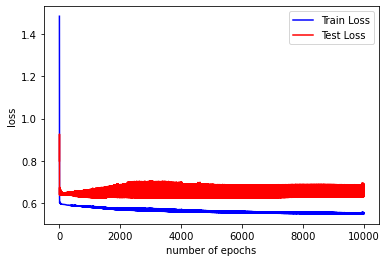

In [17]:
fig = plt.figure()
plt.plot(range(0, no_epochs), train_losses, color='blue')
plt.plot(range(0, no_epochs), test_losses, color='red')
plt.legend(['Train Loss', "Test Loss"], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('loss')

In [18]:
y_pred = net(test_x)
_, predicted = torch.max(y_pred.data, 1)
correct = (predicted == test_y).sum().item()
print(f"Accuarcy is {100. * correct / len(test_x)}%")

Accuarcy is 68.53146853146853%
